# Nvidia Stock Prediction
![nvidia_logo](images/nvidia_logo.jpg)

- Author: Kibae Kim <br>

Nvidia Corporation, an American multinational technology company designs graphics processing units (GPUs) for the gaming and professional markets, as well as system on a chip units (SoCs) for the mobile computing and automotive market. Its primary GPU line, labeled "GeForce", is in direct competition with the GPUs of the "Radeon" brand by Advanced Micro Devices (AMD)

## Overview

The data for the prediction was collected using [Yahoo Finance](https://finance.yahoo.com/) with support of pandas, numpy, and datetime library of Python. [Nvidia closing stock price](https://finance.yahoo.com/quote/NVDA/history?p=NVDA) is main dependent variable which predicted in this project, and [AMD previous day closing stock price](https://finance.yahoo.com/quote/AMD?p=AMD&.tsrc=fin-srch), [Google trend data](https://trends.google.com/trends/explore?q=nvidia&geo=US), [graphics card market share from Statista](https://www.statista.com/statistics/274005/market-share-of-global-graphics-card-shipments-since-3rd-quarter-2010/), and [Nvidia Earnings Date, Estimates & History from Market Beat](https://www.marketbeat.com/stocks/NASDAQ/NVDA/earnings/) were chosen for exogenous variables. For time series forecasting model, ARIMA, ARIMA with exogenous variables, LSTM, and Prophet were tested on daily closing price of Nvidia.

## Business Problem
It is common in financial industry to use time series forecasting to track the price of a stock over time. This can be tracked in the short term, such as the price of a stock in one hour during a business day, or in the long term, such as the price of a stock on the last day of each month. Stock markets are very unpredictable and geopolitical changes can affect the stock trend of stocks in the stock market. Recently, we faced 2020 stock market crash, caused by Covid-19, that began on 20 February 2020 and ended on 7 April. Therefore, it is very difficult to perform reliable trend analysis on with previous time series forecasting.

2021 is called the year of cryptocurrency. Cryptocurrency is a digital currency that can be used to purchase goods and services, but it uses an online ledger with strong encryption to secure your online transactions. Much of the interest in these unregulated currencies is that speculators sometimes trade for profit to increase their prices. The popularity of cryptocurrency caused a shortage in the graphics card market. At the same time, it leads increasing of stock price of a graphics card supplier, Nvidia.

I want to build a reliable time series forecasting model that predict Nvidia stock price taking into account the cryptocurrency boom and the impact of the Covid-19. Therefore, this project aims to provide an updated time series forecasting for investment banks to predict better Nvidia future stock price.

## Method
1. Nvidia's historical stock data was collected from Yahoo Finance between 6/01/2019 and 6/4/2021
2. Relationships between stock closing price and exogenous variables
3. ARIMA order for Nvidia's daily closing price were calculated
    - Auto ARIMA
4. ARIMA, ARIMA with exogenous variables built and tested
5. LSTM, Prophet will be built soon

## 1. Libraries Import

In [3]:
import os
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas.tseries.frequencies import to_offset
import datetime
import numpy as np
import itertools
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from chart_studio.plotly import plot_mpl
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from pylab import rcParams

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## 2. Data Understanding

The data for the prediction was collected using [Yahoo Finance](https://finance.yahoo.com/) with support of pandas, numpy, and datetime library of Python. [Nvidia closing stock price](https://finance.yahoo.com/quote/NVDA/history?p=NVDA) is main dependent variable which predicted in this project, and [AMD previous day closing stock price](https://finance.yahoo.com/quote/AMD?p=AMD&.tsrc=fin-srch), [Google trend data](https://trends.google.com/trends/explore?q=nvidia&geo=US), [graphics card market share from Statista](https://www.statista.com/statistics/274005/market-share-of-global-graphics-card-shipments-since-3rd-quarter-2010/), and [Nvidia Earnings Date, Estimates & History from Market Beat](https://www.marketbeat.com/stocks/NASDAQ/NVDA/earnings/) were chosen for exogenous variables.

In [126]:
# read csv datas by usinf pandas
nvidia = pd.read_csv('./data/Nvidia_history.csv')
amd = pd.read_csv('./data/AMD_stock_price_history.csv')
nvidia_trend = pd.read_csv('./data/Nvidia_google_trend.csv')

In [127]:
nvidia.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Revenue,Future,Market_share
0,1/22/1999,1.750000,1.953125,1.552083,1.640625,1.507891,67867200,NaN,NaN,NaN
1,1/25/1999,1.770833,1.833333,1.640625,1.812500,1.665861,12762000,NaN,NaN,NaN
2,1/26/1999,1.833333,1.869792,1.645833,1.671875,1.536613,8580000,NaN,NaN,NaN
3,1/27/1999,1.677083,1.718750,1.583333,1.666667,1.531826,6109200,NaN,NaN,NaN
4,1/28/1999,1.666667,1.677083,1.651042,1.661458,1.527039,5688000,NaN,NaN,NaN


In [128]:
amd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/17/1980,0.0,3.302083,3.125000,3.145833,3.145833,219600
1,3/18/1980,0.0,3.125000,2.937500,3.031250,3.031250,727200
2,3/19/1980,0.0,3.083333,3.020833,3.041667,3.041667,295200
3,3/20/1980,0.0,3.062500,3.010417,3.010417,3.010417,159600
4,3/21/1980,0.0,3.020833,2.906250,2.916667,2.916667,130800


In [129]:
nvidia_trend.head()

,Month,Nvidia
0,2004-01,96
1,2004-02,80
2,2004-03,88
3,2004-04,84
4,2004-05,79


## 3. Data Preparation

Drop Adjusted Close price from nvidia dataframe

In [130]:
# drop Adjusted Close price
nvidia = nvidia.drop(columns='Adj Close')

Calculate daily change from open to close price, and add previous day's daily_change column in nvidia dataframe

In [131]:
# calculate daily change and add column in nvidia dataframe
nvidia['daily_change'] = (nvidia.Close - nvidia.Open) / nvidia.Open * 100

Add previous day's stock closing price in nvidia dataframe

In [132]:
# add previous day's AMD Stock closing price as a column in nvidia dataframe
amd['amd_close_price'] = amd['Close']
amd.drop(columns=['Open', 'High', 'Low', 'Adj Close','Volume', 'Close'], inplace=True)
nvidia = nvidia.merge(amd, on='Date', how='left')

Change data type of Revenue to float

In [133]:
nvidia1 = nvidia['Revenue'].str.strip('$').str.extract(r'(\d+\.\d+)([BM]+)')
nvidia['Revenue'] = nvidia1[0].astype(float) * nvidia1[1].map({'B': 1000000000, 'M':1000000})

Add monthly Google trend result in nvidia dataframe

In [134]:
# make trend list to add trend column in nvidia dataframe
trend = []
for date in nvidia['Date']:
    month = date.split('/')[0]
    if int(month) < 10:
        month = f'0{month}'
    else:
        month = month
    year = date.split('/')[2]
    year_month = f'{year}-{month}'
    if int(year) < 2004:
        trend.append(0)
    else:
        trend.append(int(nvidia_trend.Nvidia[nvidia_trend.Month == year_month]))

# add trend column with the list of trend
nvidia['trend'] = trend
nvidia['trend'] = nvidia['trend'].astype(int)

Set date as index of nvidia dataframe

In [135]:
# change type of nvidia Date column to datetime
nvidia['Date'] = pd.to_datetime(nvidia['Date'])

# set Date column as index of nvidia dataframe
nvidia = nvidia.set_index('Date')

Make future variable's dummy variables and shifted nvidia dataframe

In [136]:
# make dummy variable
nvidia = pd.get_dummies(nvidia, prefix='future', drop_first=True)

# make shifted nvidia dataframe
shift_nvidia = nvidia.shift(1)
shift_nvidia['close'] = nvidia.Close
shift_nvidia.drop(columns=['Close'], inplace=True)

## 4. EDA

The collected Nvidia stock history data from Yahoo Finance is clean and did not have nan values. The data includes date, open, high, low, close, adj close, and volume, and I added revenue, future, and market share from Market Beat and Statista. For this project Nvidia closing price will be predicted.

### 1. Nvidia Closing Stock History

#### Between 09/16/2018 and 06/01/2019
Concerns about rising interest rates, a slowing global economy and particularly slowing demand for semiconductors and the escalating trade war with China were likely the main reasons for the market jitters. NVIDIA stock declined. In addition, Nvidia's release of third-quarter results along with fourth-quarter guidance on 11/15/2018, that disappointed the market. The slope of the graph changed before and after the stock price plunged in this period. After the stock price plunged in this period, The slope of the stock price upward graph increased.

#### Between 02/20/2020 and 04/07/2020
The 2020 stock market crash was a major and sudden global stock market crash that began on 2/20/2020 and ended on 04/07/2020, and Nvidia's stock closing price also decreased in this period. However, the period was short, and the stock immediately recovered the previous share price.

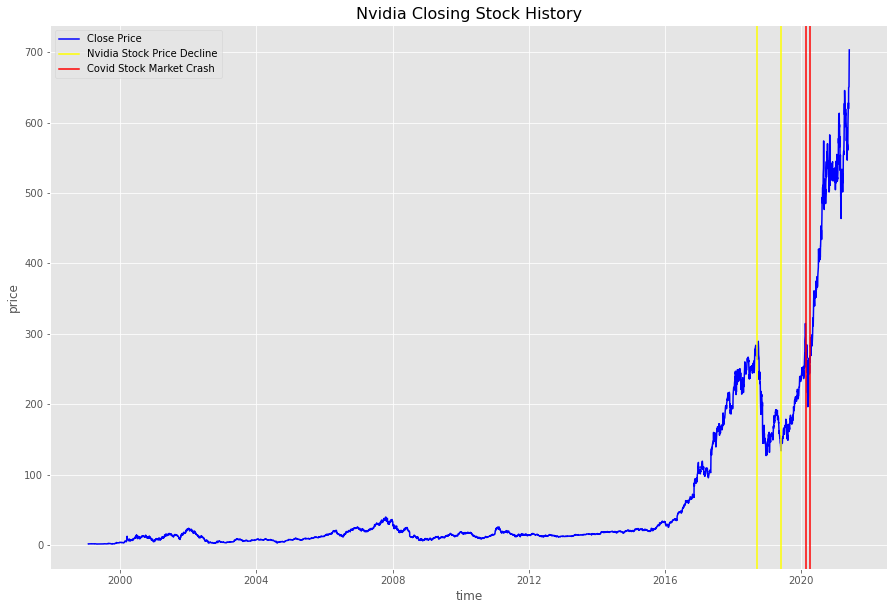

In [137]:
# create plot of Nvidia closing stock history with two significant events
plt.figure(figsize=(15,10))
plt.plot(nvidia.Close, color='blue',label='Close Price')
plt.axvline(x='2018-09-16', color='yellow')
plt.axvline(x='2019-06-01', color='yellow', label='Nvidia Stock Price Decline')
plt.axvline(x='2020-02-20', color='red')
plt.axvline(x='2020-04-07', color='red', label='Covid Stock Market Crash')
plt.legend(loc='best')
plt.title('Nvidia Closing Stock History', fontsize=16)
plt.xlabel("time")
plt.ylabel("price")
plt.savefig('./images/nvidia_stock_history.png')
plt.show()

So, I decided to use stock price history from 6/1/2019.

In [138]:
# choose data from 6/1/2019 from nvidia dataframe
nvidia = nvidia[nvidia.index >= '2019-06-01']
shift_nvidia = shift_nvidia[shift_nvidia.index >= '2019-06-01']

### 2. Relationship Betweeen Nvidia Closing Price and Exogenous Variables

I chose quarterly reported revenue of Nvidia, Nvidia graphics card's market share, previous AMD stock closing price, and Google trend as possible exogenous variables for ARIMA model. There are positive relationships between Nvidia closing stock price and exogenous variables.

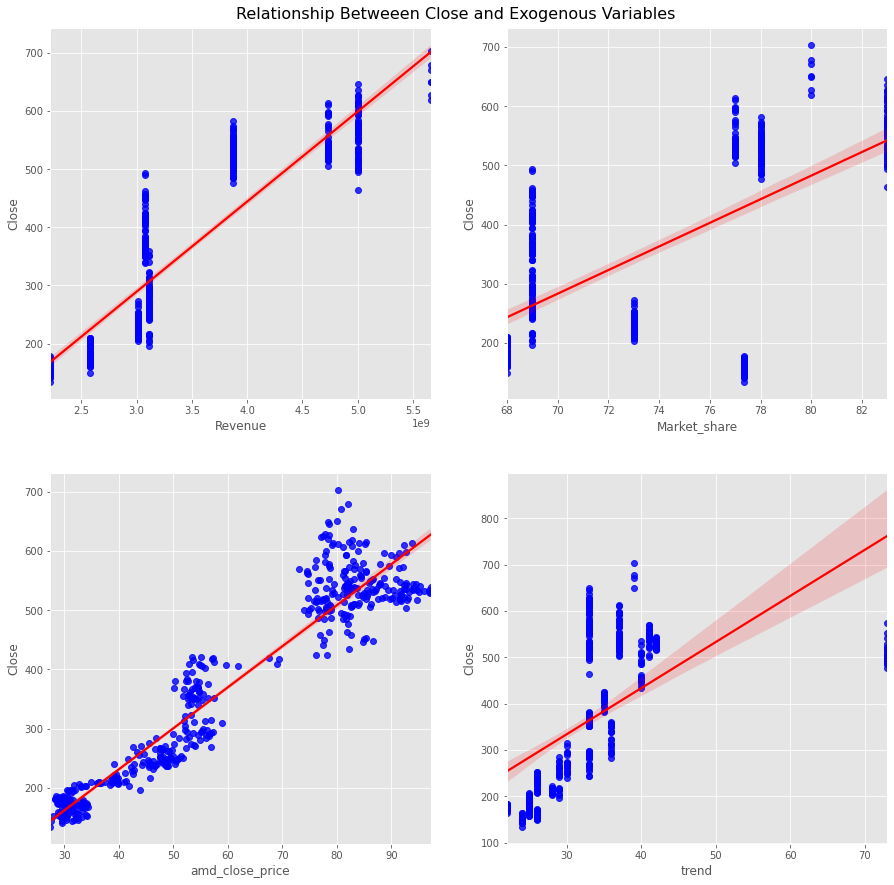

In [139]:
# create regression plots to check the relationship between closing price and other variables
fig, axes = plt.subplots(2, 2, figsize=(15,15))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]
X = nvidia.drop('Close', axis = 1)
y = nvidia['Close']
fig.suptitle('Relationship Betweeen Close and Exogenous Variables', fontsize=16, y=0.9)
sns.regplot(x=X['Revenue'], y=y, line_kws={"color": "red"}, ax=ax1, color='blue')
sns.regplot(x=X['Market_share'], y=y, line_kws={"color": "red"}, ax=ax2, color='blue')
sns.regplot(x=shift_nvidia['amd_close_price'], y=y, line_kws={"color": "red"}, ax=ax3, color='blue')
sns.regplot(x=X['trend'], y=y, line_kws={"color": "red"}, ax=ax4, color='blue')
fig.savefig('./images/close_variables_relationship.png')

### Stationality and Seasonality

The P-value of Nvidia stock closing price is 0.97, which is higher than 0.05, so it doesn't have stationarity. Also, it doesn't have seasonality neither according to decomposition of Nvidia stock closing price.

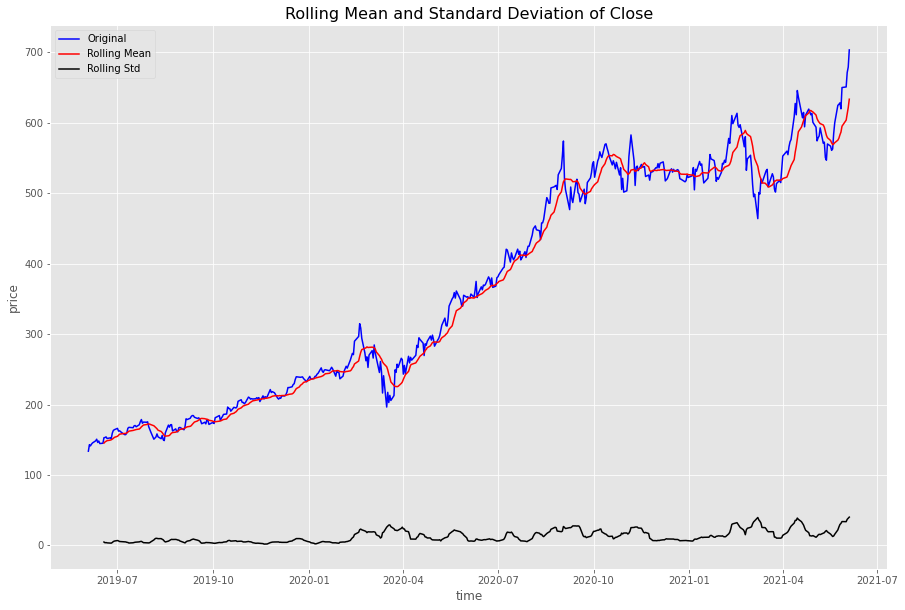

Results of dickey fuller test
Test Statistics                  0.110537
p-value                          0.966773
No. of lags used                 1.000000
Number of observations used    505.000000
critical value (1%)             -3.443366
critical value (5%)             -2.867280
critical value (10%)            -2.569827
dtype: float64


In [140]:
# create rolling mean and standard devidation of closing price, get the results of dickey fuller test
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Close', fontsize=16)
    plt.xlabel("time")
    plt.ylabel("price")
    plt.savefig('./images/close_rolling_mean_std.png')
    plt.show()
    
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
    
test_stationarity(nvidia.Close)


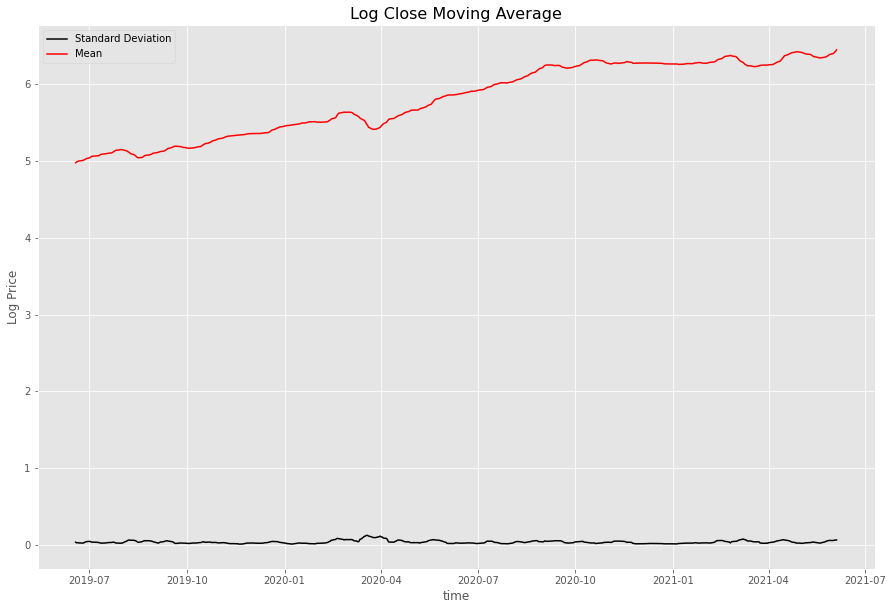

In [141]:
# create log close price moving average and standard deviation
rcParams['figure.figsize'] = 10, 6
nvidia_stock_log = np.log(nvidia.Close)
moving_avg = nvidia_stock_log.rolling(12).mean()
std_dev = nvidia_stock_log.rolling(12).std()
plt.figure(figsize=(15,10))
plt.legend(loc='best')
plt.title('Log Close Moving Average', fontsize=16)
plt.xlabel("time")
plt.ylabel("Log Price")
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.savefig('./images/log_close_moving_average.png')
plt.show()

<Figure size 720x432 with 0 Axes>

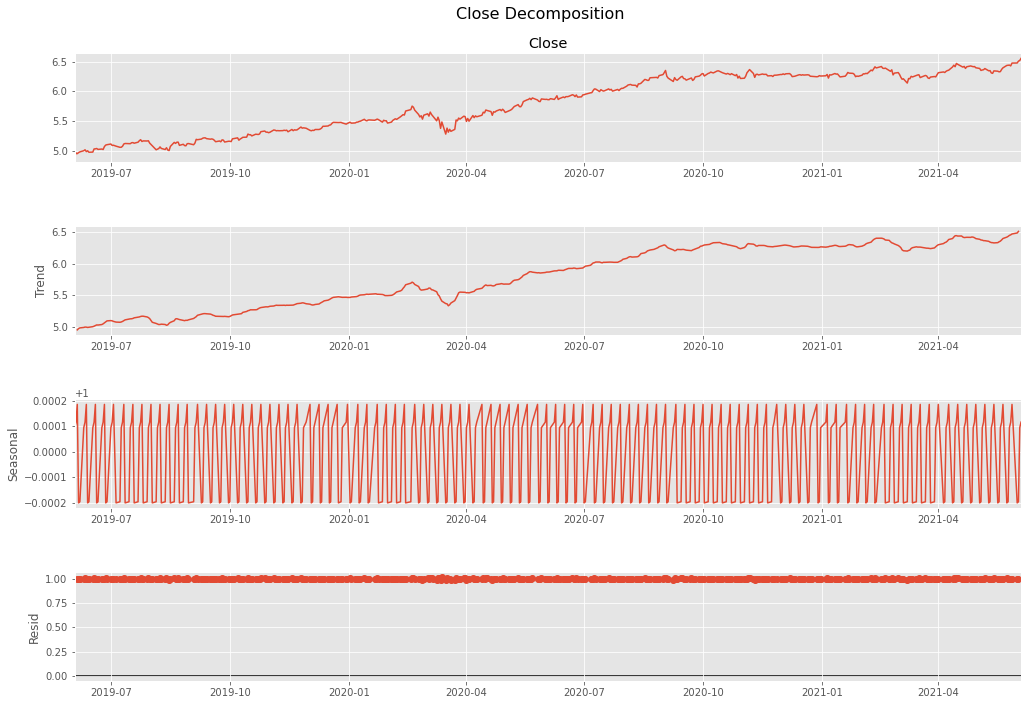

In [142]:
result = seasonal_decompose(nvidia_stock_log, model='multiplicative', period=5)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)
fig.suptitle('Close Decomposition', fontsize=16, x = 0.54, y=1)
fig.savefig('./images/close_dcompose.png')

## Model and Result

The model will be built with ARIMA (AutoRegressive Integrated Moving Average) model by using log value of Nvidia's closing stock price and will be tested on predicting from 2021 with Nvidia's closing stock price so far. The strategy is following:

1. Split data for forward propagation testing
    - predict Nvidia's closing stock price from 2021
2. Create ARIMA model
    - build ARIMA model with Nvidia's closing stock price history
3. Calculate best ARIMA order
    - Auto ARIMA
4. Compare each model performance
    - RMSE

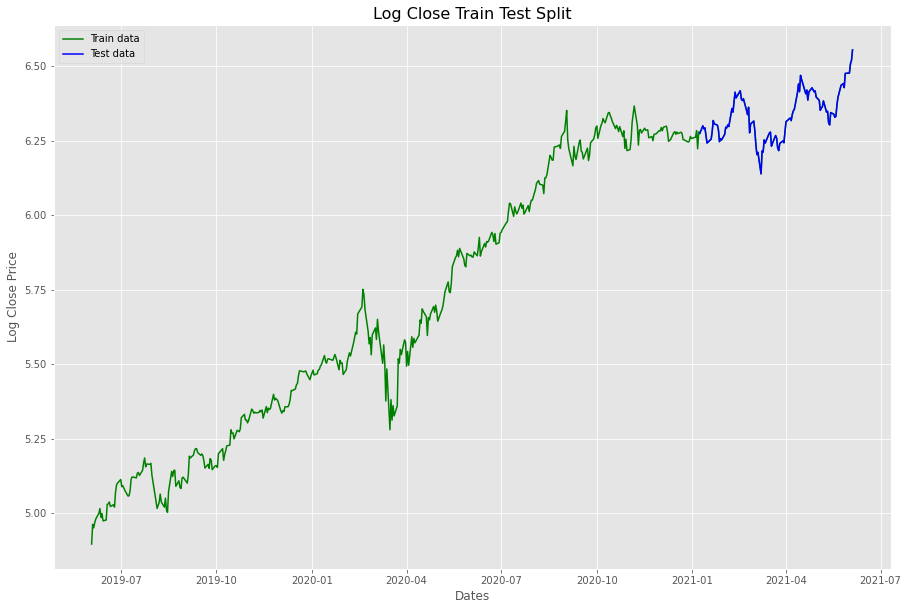

In [143]:
# split train and test with 8:2 ratio
train_data, test_data = nvidia_stock_log[3:int(len(nvidia_stock_log)*0.80)], nvidia_stock_log[int(len(nvidia_stock_log)*0.80):]
plt.figure(figsize=(15,10))
plt.grid(True)
plt.title('Log Close Train Test Split', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Log Close Price')
plt.plot(nvidia_stock_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.savefig('./images/log_close_train_test_split.png')

### ARIMA

To prepare the ARIMA model for forecasting on our data few parameters must be calculated and analyzed. However, I used Auto ARIMA to get those parameters. According to Auto ARIMA result, ARIMA(2,1,0) is the best model for this forecasting.

In [144]:
# find best order for ARIMA model by using Auto ARIMA
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1612.309, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1638.257, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1633.260, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1610.205, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1638.992, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1637.173, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1637.046, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1638.221, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1635.039, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1635.333, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.381 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  402
Model:               SARIMAX(2, 1, 0)   Log Likeliho

#### Plot Diagnostics of ARIMA
1. Standardized residual: The residual errors seem to fluctuate around a mean of zero.

2. Histogram: The density plot suggests normal distribution with mean shifted towards right.

3. Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

4. Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So, I will need to look for more X’s (predictors) to the model.

Overall, the model seems to be a good fit. So, I use it to forecast.

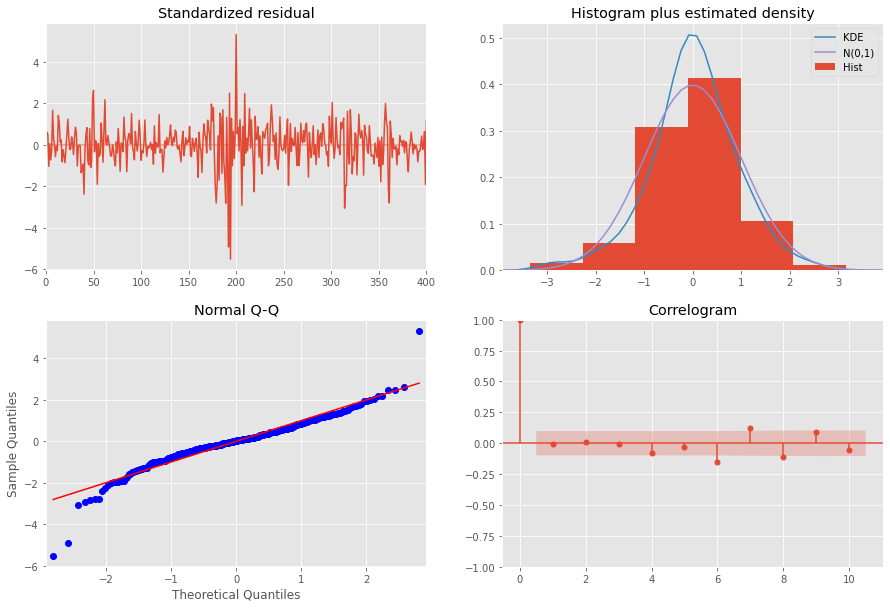

In [145]:
# plotting diagnostics of Auto ARIMA
model_autoARIMA.plot_diagnostics(figsize=(15,10))
plt.savefig('./images/plot_diagnostics_ARIMA.png')
plt.show()

#### Building ARIMA

Even though, Nvidia's stock closing price was in the 95% confidence interval, Prediction of ARIMA model order of (2, 1, 0) on Nvidia stock closing price was not closed to true value.

In [146]:
# build ARIMA model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  401
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 823.496
Method:                       css-mle   S.D. of innovations              0.031
Date:                Mon, 21 Jun 2021   AIC                          -1638.992
Time:                        22:52:26   BIC                          -1623.016
Sample:                             1   HQIC                         -1632.666
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.001      2.418      0.016       0.001       0.006
ar.L1.D.Close    -0.2390      0.050     -4.801      0.000      -0.337      -0.141
ar.L2.D.Close     0.0828      0.050     

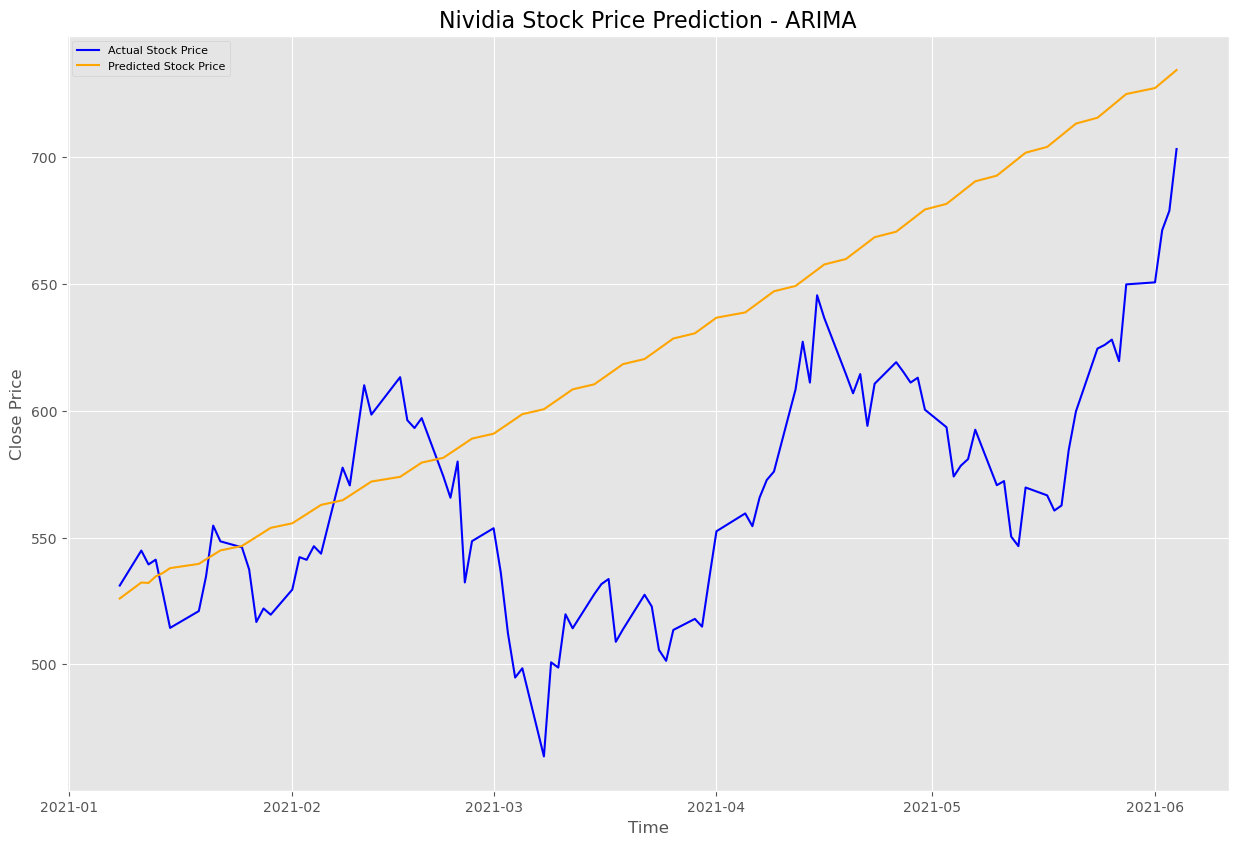

In [147]:
# Forecast
fc, se, conf = fitted.forecast(102, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
original_fc_series = np.exp(fc_series)
original_test_data = np.exp(test_data)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(original_test_data, color = 'blue', label='Actual Stock Price')
plt.plot(original_fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('Nividia Stock Price Prediction - ARIMA', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_prediction_result.png')
plt.show()

#### Result of ARIMA model


Overall, ARIMA of (2, 1, 0) performed with:
 - RMSE: 77.55
 - %RMSE: 0.14

In [148]:
MSE = np.square(np.subtract(original_test_data,original_fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/original_test_data.mean())

RMSE: 77.54768841113614
%RMSE:  0.1369453158547312


### ARIMA with Exogenous Variables

To prepare the ARIMA with exogenous variables model for forecasting on our data few parameters must be calculated and analyzed. However, I used Auto ARIMA to get those parameters. According to Auto ARIMA result, ARIMA(3,1,0) is the best model for this forecasting.

In [159]:
# drop exogenous variables which are not going to be used in this model and split into train and test with 8:2 ratio
exo_df = shift_nvidia.drop(columns=['close','trend', 'daily_change','future_same', 'future_up'])
train_exo_data, test_exo_data = exo_df[3:int(len(exo_df)*0.80)], exo_df[int(len(exo_df)*0.80):]

# scale train_exo_data and test_exo_data
transformer = MinMaxScaler()
train_exo = transformer.fit_transform(train_exo_data)
test_exo = transformer.transform(test_exo_data)
train_exo=pd.DataFrame(data=train_exo, index=train_exo_data.index, columns=train_exo_data.columns)
test_exo=pd.DataFrame(data=test_exo, index=test_exo_data.index, columns=test_exo_data.columns)

In [162]:
# find best order for ARIMA with exogenous variables model by using Auto ARIMA
model_autoARIMA_exo = auto_arima(train_data, exogenous=train_exo, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=4, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_exo.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1624.384, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1657.476, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1640.306, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1621.062, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1650.886, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1653.966, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1653.038, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1654.093, Time=0.71 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.533 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  402
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 838.738
Date:                Mon, 21 Jun 2021   AIC                          -1657.476
Time:                       

#### Plot Diagnostics of ARIMA with Exogenous Variables
1. Standardized residual: The residual errors seem to fluctuate around a mean of zero.

2. Histogram: The density plot suggests normal distribution with mean shifted towards right.

3. Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

4. Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So, I will need to look for more X’s (predictors) to the model.

Overall, the model seems to be a good fit. So, I use it to forecast.

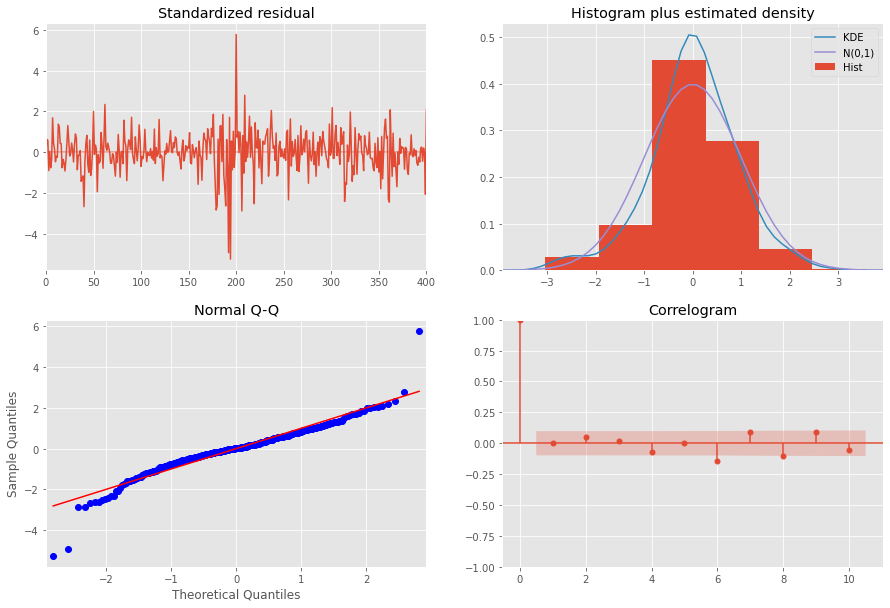

In [163]:
model_autoARIMA_exo.plot_diagnostics(figsize=(15,10))
plt.savefig('./images/plot_diagnostics_ARIMA_exo.png')
plt.show()

#### Building ARIMA with Exogenous Variables

Fitting ARIMA with exogenous variables model orders of (3, 1, 0) on Nvidia stock closing price resulted in much closer prediction in true value than ARIMA model.

In [164]:
# build ARIMA with exogenous variables model
model2 = ARIMA(train_data, exog=train_exo, order=(2, 1, 0))  
fitted2 = model2.fit()  
print(fitted2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  401
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 833.120
Method:                       css-mle   S.D. of innovations              0.030
Date:                Mon, 21 Jun 2021   AIC                          -1644.241
Time:                        22:54:49   BIC                          -1600.307
Sample:                             1   HQIC                         -1626.844
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0051      0.004      1.392      0.164      -0.002       0.012
Open               -0.6562      0.160     -4.111      0.000      -0.969      -0.343
High                0.2850      

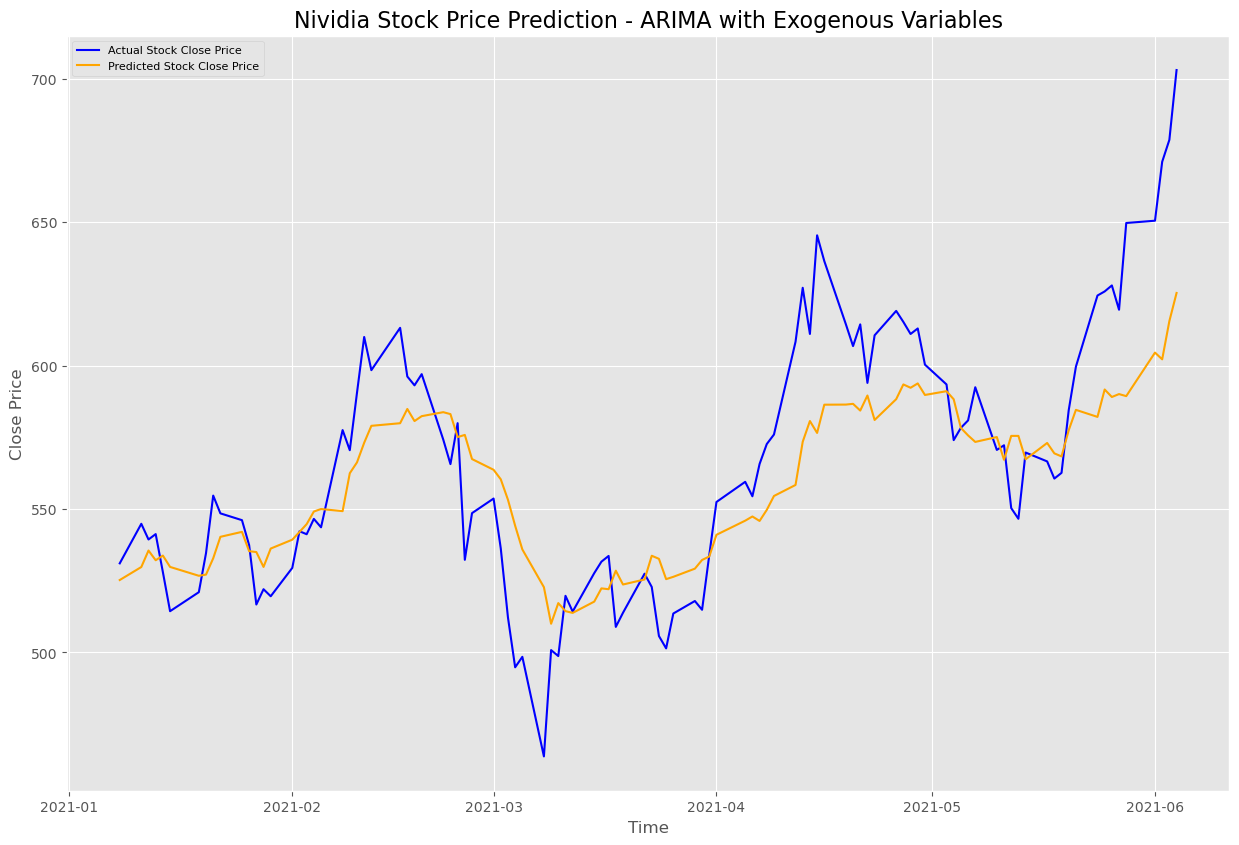

In [165]:
# Forecast
fc, se, conf = fitted2.forecast(102, exog=test_exo, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
original_fc_series = np.exp(fc_series)
original_test_data = np.exp(test_data)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(original_test_data, color = 'blue', label='Actual Stock Close Price')
plt.plot(original_fc_series, color = 'orange',label='Predicted Stock Close Price')
plt.title('Nividia Stock Price Prediction - ARIMA with Exogenous Variables', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_exo_prediction_result.png')
plt.show()

#### Result of ARIMA with exogenous variables model

Overall, ARIMA of (3, 1, 0) performed with:
 - RMSE: 26.49
 - %RMSE: 0.047

In [166]:
MSE = np.square(np.subtract(original_test_data,original_fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/original_test_data.mean())

RMSE: 26.485531385530958
%RMSE:  0.04677211578431876


In [34]:
transformer = MinMaxScaler()
exo_df_scaled = transformer.fit_transform(exo_df)
exo_df_scaled=pd.DataFrame(data=exo_df_scaled, index=exo_df.index, columns=exo_df.columns)

In [172]:
nvidia_stock_log.head()

Date
2019-06-03    4.896197
2019-06-04    4.962845
2019-06-05    4.950744
2019-06-06    4.968284
2019-06-07    4.980176
Name: Close, dtype: float64

In [179]:
exo_df_scaled.tail()

,Open,High,Low,Volume,Revenue,Market_share,amd_close_price
Date,,,,,,,
2021-05-28,0.924754,0.890828,0.915360,0.354072,1.0,0.8,0.730384
2021-06-01,0.909813,0.928991,0.918450,0.400243,1.0,0.8,0.754152
2021-06-02,0.967620,0.937004,0.948768,0.274506,1.0,0.8,0.764605
2021-06-03,0.966286,0.975384,0.973809,0.363365,1.0,0.8,0.781214
2021-06-04,1.000000,1.000000,1.000000,0.352998,1.0,0.8,0.757016


In [186]:
nvidia['Close'].tail()

Date
2021-05-28    649.780029
2021-06-01    650.580017
2021-06-02    671.130005
2021-06-03    678.789978
2021-06-04    703.130005
Name: Close, dtype: float64

In [198]:
model3 = ARIMA(nvidia['Close'], order=(2, 1, 0))  
fitted3 = model3.fit()  
print(fitted3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  506
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1956.605
Method:                       css-mle   S.D. of innovations             11.563
Date:                Mon, 21 Jun 2021   AIC                           3919.211
Time:                        18:26:09   BIC                           3931.890
Sample:                             1   HQIC                          3924.184
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Close    -0.1405      0.045     -3.156      0.002      -0.228      -0.053
ar.L2.D.Close     0.0717      0.045      1.612      0.107      -0.015       0.159
                                    Root

In [199]:
model3.

SyntaxError: invalid syntax (<ipython-input-199-8dfd989c5f69>, line 1)

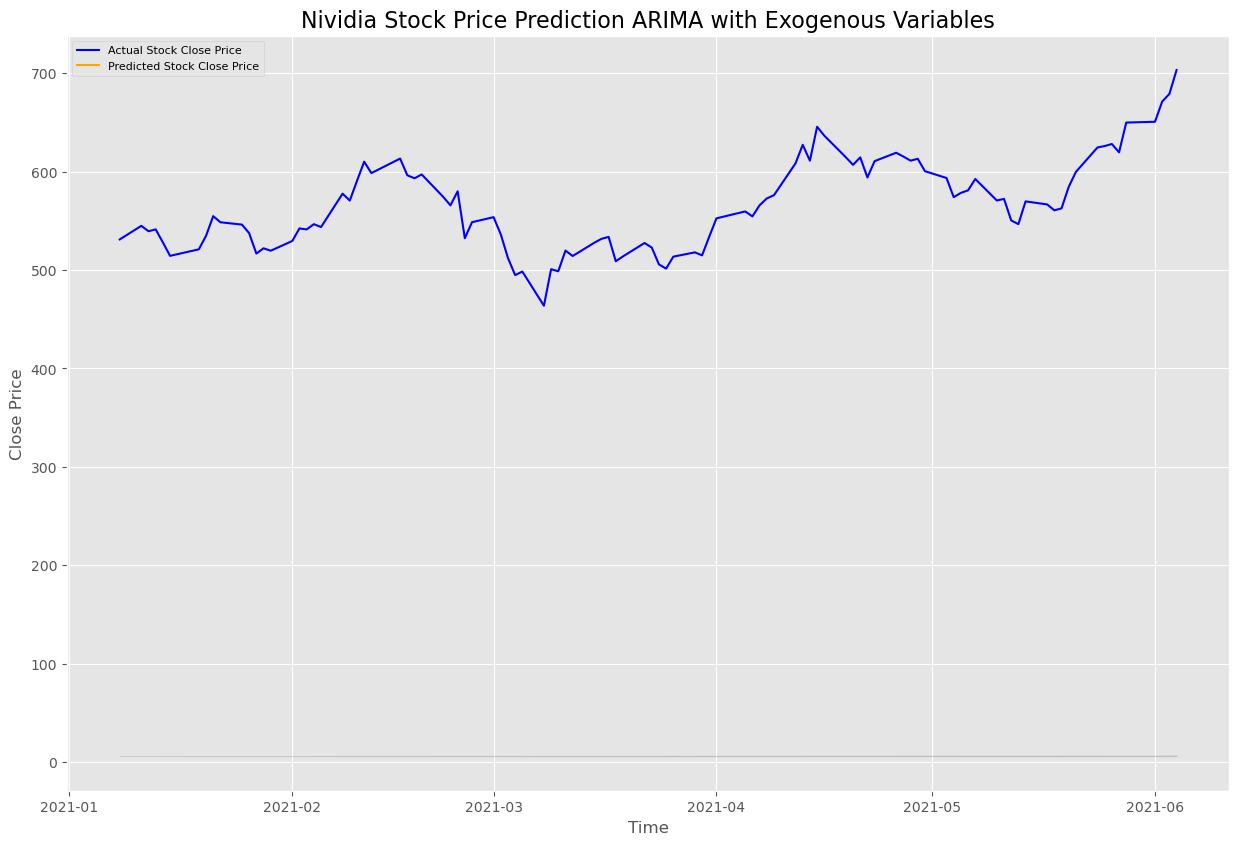

In [200]:
prediction = fitted3.predict(start=len(train_data), end=len(nvidia_stock_log))
prediction = pd.Series(prediction, index=test_data.index)
# original_prediction = np.exp(prediction)
# original_test_data = np.exp(test_data)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(original_test_data, color = 'blue', label='Actual Stock Close Price')
plt.plot(original_prediction, color = 'orange',label='Predicted Stock Close Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction - ARIMA with Exogenous Variables', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_exo_prediction_result.png')
plt.show()

In [201]:
fitted3.predict(start=len(train_data), end=len(nvidia_stock_log))


401   -0.589254
402   -1.469204
403    5.277745
404   -6.368318
405    2.471542
         ...   
502   -4.860603
503    2.058606
504   -2.830333
505    0.397975
506   -2.870744
Length: 106, dtype: float64

In [176]:
prediction

Date
2021-01-08   NaN
2021-01-11   NaN
2021-01-12   NaN
2021-01-13   NaN
2021-01-14   NaN
              ..
2021-05-28   NaN
2021-06-01   NaN
2021-06-02   NaN
2021-06-03   NaN
2021-06-04   NaN
Length: 102, dtype: float64

In [116]:
test_data

Date
2021-01-08    6.274894
2021-01-11    6.300529
2021-01-12    6.290439
2021-01-13    6.293918
2021-01-14    6.269115
                ...   
2021-05-28    6.476634
2021-06-01    6.477864
2021-06-02    6.508963
2021-06-03    6.520312
2021-06-04    6.555542
Name: Close, Length: 102, dtype: float64

In [167]:
nvidia['close'] = nvidia['Close']
nvidia_droped = nvidia.drop(columns=['Close', 'trend', 'daily_change','future_same', 'future_up'])
train, test = nvidia_droped[3:int(len(nvidia_droped)*0.80)], nvidia_droped[int(len(nvidia_droped)*0.80):]

In [168]:
transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train)
test_scaled = transformer.transform(test)

In [169]:
sequence_length = 5
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train_scaled[i:i + window_length]
    x_train.append(window[:-1, :])
    y_train.append(window[-1, [-1]])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test_scaled[i:i + window_length, :]
    x_test.append(window[:-1, :])
    y_test.append(window[-1, [-1]])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [170]:
model = Sequential()
model.add(LSTM(units=512, input_shape=(5, 8)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1))

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1067008   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 1,330,177
Trainable params: 1,330,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 3s 75ms/step - loss: 0.1006 - val_loss: 0.0600
Epoch 2/50
13/13 [==============================] - 0s 31ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 3/50
13/13 [==============================] - 0s 31ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 4/50
13/13 [==============================] - 0s 31ms/step - loss: 0.00

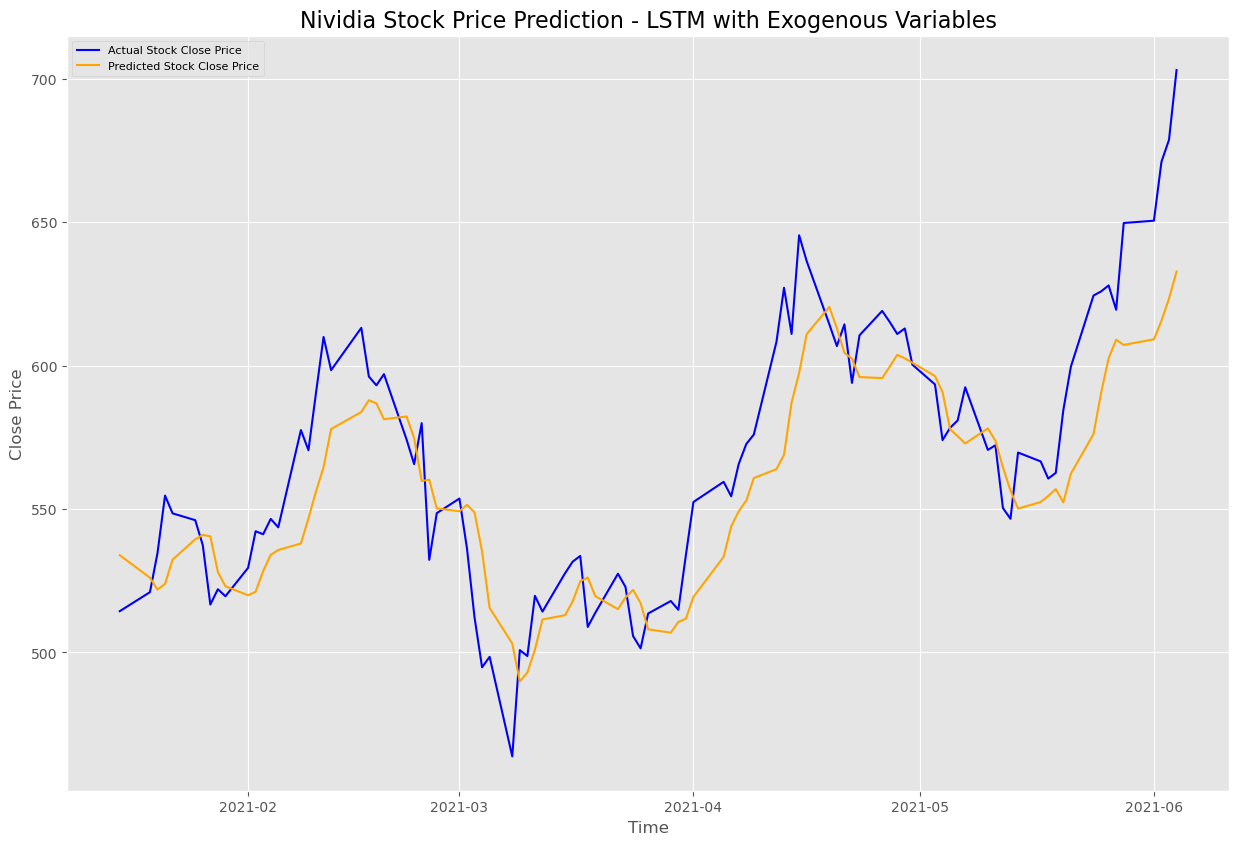

In [171]:
y_predicts = model.predict(x_test)
y_predict_inv_scaled = y_predicts*(train.close.max()-train.close.min())+train.close.min()
y_predict = []
for predict in y_predict_inv_scaled:
    y_predict.append(predict[0])

y_predict = pd.Series(y_predict, index=test_data.index[5:])


y_test_inv_scaled = y_test*(train.close.max()-train.close.min())+train.close.min()
y_test = []
for predict in y_test_inv_scaled:
    y_test.append(predict[0])
    
y_test = pd.Series(y_test, index=test_data.index[5:])

plt.figure(figsize=(15,10), dpi=100)
plt.plot(y_test, color = 'blue', label='Actual Stock Close Price')
plt.plot(y_predict, color = 'orange',label='Predicted Stock Close Price')
plt.title('Nividia Stock Price Prediction - LSTM with Exogenous Variables', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/LSTM_result.png')
plt.show()

In [172]:
MSE = np.square(np.subtract(y_test,y_predict)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/y_test.mean())

RMSE: 23.952450200695537
%RMSE:  0.04218612341500415


In [81]:
shift_nvidia

,Open,High,Low,Volume,Revenue,Market_share,daily_change,amd_close_price,trend,future_same,future_up,close
Date,,,,,,,,,,,,
2019-06-03,137.139999,139.850006,135.389999,9743000.0,2.220000e+09,77.33,-1.225020,27.410000,23.0,1.0,0.0,133.779999
2019-06-04,135.910004,137.470001,132.600006,11966100.0,2.220000e+09,77.33,-1.567217,27.580000,24.0,1.0,0.0,143.000000
2019-06-05,136.360001,143.210007,135.470001,16045900.0,2.220000e+09,77.33,4.869462,29.570000,24.0,1.0,0.0,141.279999
2019-06-06,145.970001,146.190002,139.820007,12790400.0,2.220000e+09,77.33,-3.212990,29.500000,24.0,1.0,0.0,143.779999
2019-06-07,141.449997,144.770004,141.350006,10203500.0,2.220000e+09,77.33,1.647227,31.820000,24.0,1.0,0.0,145.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,627.989990,630.000000,618.400024,14536900.0,5.660000e+09,80.00,-1.348743,78.419998,33.0,0.0,0.0,649.780029
2021-06-01,620.039978,651.099976,620.039978,16113400.0,5.660000e+09,80.00,4.796473,80.080002,33.0,0.0,0.0,650.580017
2021-06-02,650.799988,655.530029,636.130005,11820100.0,5.660000e+09,80.00,-0.033800,80.809998,39.0,0.0,0.0,671.130005


In [173]:
nvidia_dropped = shift_nvidia.rename(columns = {'close':'y'})
nvidia_dropped['ds']= nvidia_dropped.index
train, test = nvidia_dropped[3:int(len(nvidia_dropped)*0.80)], nvidia_dropped[int(len(nvidia_dropped)*0.80):]

In [174]:
# The Prophet class (model)
fbp = Prophet(yearly_seasonality=True, daily_seasonality=True) 
 # Fit the model 
fbp.fit(nvidia_dropped)
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=20) 
forecast = fbp.predict(test)

In [175]:
# A better plot than the simple matplotlib
plot_plotly(fbp, forecast)

In [176]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-08,502.512468,516.428127,556.919875,502.512468,502.512468,34.235583,34.235583,34.235583,26.366236,...,2.246375,2.246375,2.246375,5.622972,5.622972,5.622972,0.0,0.0,0.0,536.748051
1,2021-01-11,505.158765,514.167223,554.762059,505.158765,505.158765,29.304297,29.304297,29.304297,26.366236,...,0.873548,0.873548,0.873548,2.064513,2.064513,2.064513,0.0,0.0,0.0,534.463063
2,2021-01-12,506.040864,514.693797,554.461053,506.040864,506.040864,28.218890,28.218890,28.218890,26.366236,...,1.086999,1.086999,1.086999,0.765655,0.765655,0.765655,0.0,0.0,0.0,534.259754
3,2021-01-13,506.922963,513.910969,555.358412,506.922963,506.922963,27.169957,27.169957,27.169957,26.366236,...,1.361161,1.361161,1.361161,-0.557441,-0.557441,-0.557441,0.0,0.0,0.0,534.092920
4,2021-01-14,507.805062,512.657426,553.584309,507.805062,507.805062,25.506841,25.506841,25.506841,26.366236,...,1.023476,1.023476,1.023476,-1.882872,-1.882872,-1.882872,0.0,0.0,0.0,533.311903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2021-05-28,626.006317,612.580749,653.088458,626.006317,626.006317,7.010370,7.010370,7.010370,26.366236,...,2.246375,2.246375,2.246375,-21.602240,-21.602240,-21.602240,0.0,0.0,0.0,633.016688
98,2021-06-01,629.534713,622.415491,662.532615,629.534713,629.534713,12.296125,12.296125,12.296125,26.366236,...,1.086999,1.086999,1.086999,-15.157111,-15.157111,-15.157111,0.0,0.0,0.0,641.830837
99,2021-06-02,630.416812,624.714282,662.993023,630.416812,630.416812,13.728881,13.728881,13.728881,26.366236,...,1.361161,1.361161,1.361161,-13.998517,-13.998517,-13.998517,0.0,0.0,0.0,644.145693
100,2021-06-03,631.298911,625.500438,666.089962,631.298911,631.298911,14.349726,14.349726,14.349726,26.366236,...,1.023476,1.023476,1.023476,-13.039987,-13.039987,-13.039987,0.0,0.0,0.0,645.648637


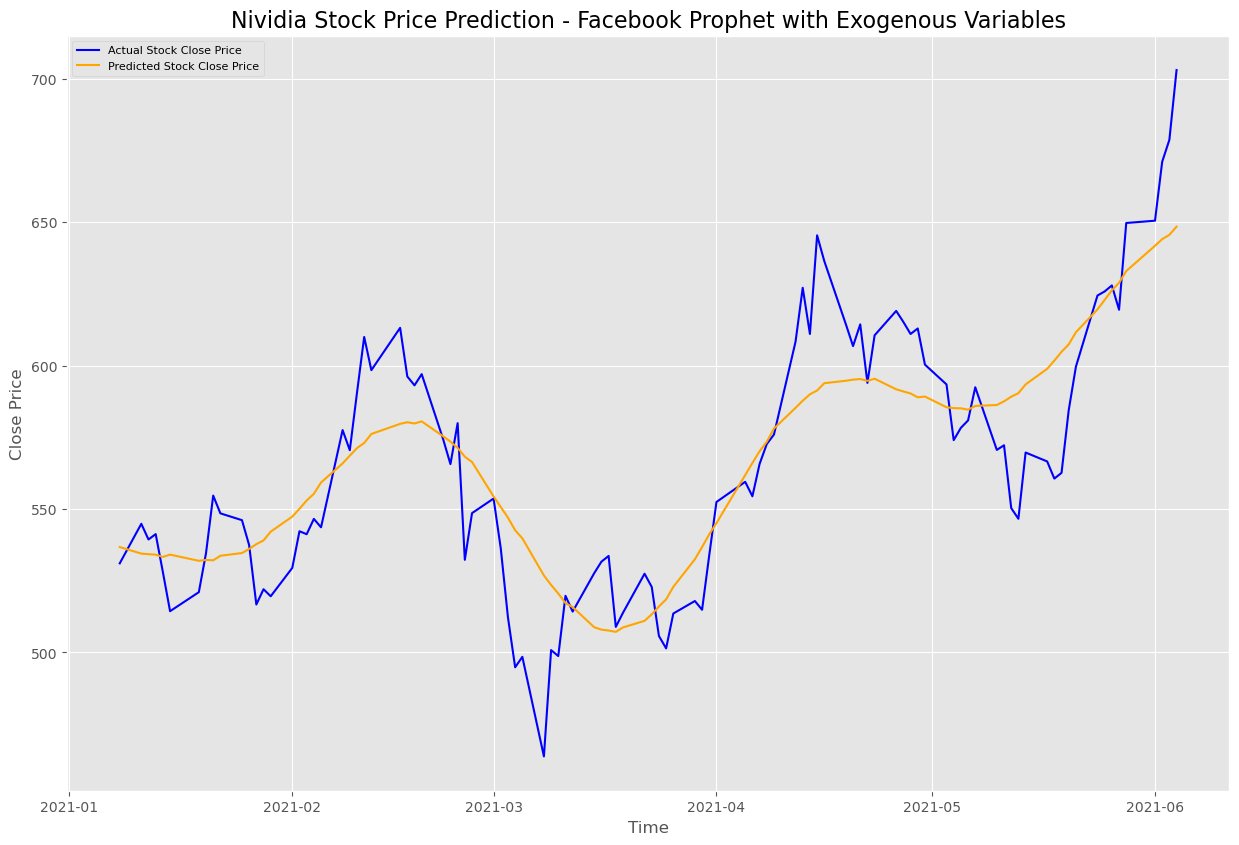

In [177]:
forecast_df = forecast.set_index('ds')
plt.figure(figsize=(15,10), dpi=100)
plt.plot(test.y, color = 'blue', label='Actual Stock Close Price')
plt.plot(forecast_df.yhat, color = 'orange',label='Predicted Stock Close Price')
plt.title('Nividia Stock Price Prediction - Facebook Prophet with Exogenous Variables', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/prophet_result.png')


In [178]:
MSE = np.square(np.subtract(test.y,forecast_df.yhat)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/y_test.mean())

RMSE: 22.047606130301492
%RMSE:  0.03883122709472504


## Conclusion

Trading year 2020 had market movements, especially with COVID-19 crash but fortunately, its effect on Nvidia stock closing price was low and Nvidia recovered its stock closing price quickly. Overall, the prediction made in this project yielded good insights to market trend using ARIMA with exogenous variables to predict Nvidia future stock closing price. The project will help investment banks to predict Nvidia's future stock prices.

## Future Work

1. Test with LSTM and Prophet model
2. Find other exogenous variables

-------------------------------------------------------------------------------------------------------

below here is not a part of this notebook. these are for future step

In [ ]:
# n_periods = 24
# fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)


date_string = "2021-06-09"
date = datetime.strptime(date_string, "%Y-%m-%d")

fc, se, conf = fitted.forecast(5, alpha=0.05)
index_of_fc = np.arange(nvidia_stock_log.index[-1], date)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(conf[:, 0], index=index_of_fc)
upper_series = pd.Series(conf[:, 1], index=index_of_fc)

# Plot
plt.plot(nvidia_stock_log)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

(array([0.00142272, 0.00369906, 0.01308898, 0.05890041, 0.20515553,
        0.13885701, 0.03357608, 0.00341452, 0.00113817, 0.00085363]),
 array([-10.38111455,  -8.20770281,  -6.03429108,  -3.86087934,
         -1.6874676 ,   0.48594414,   2.65935587,   4.83276761,
          7.00617935,   9.17959108,  11.35300282]),
 <BarContainer object of 10 artists>)

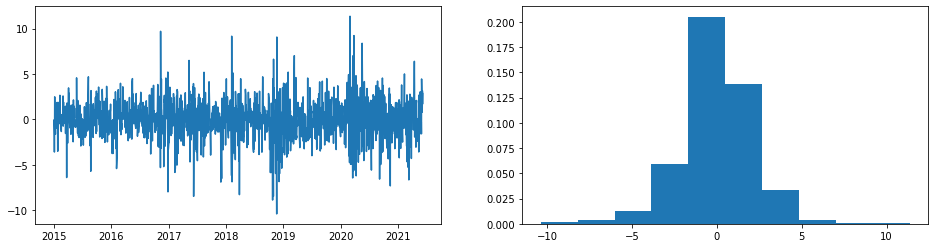

In [584]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

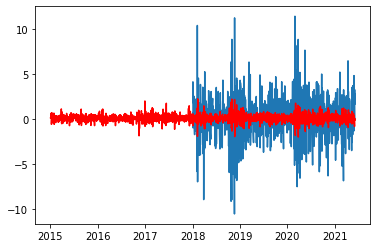

In [585]:
plt.plot(df.daily_change)
plt.plot(result.fittedvalues, color='red')
plt.show()

In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

In [ ]:
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2020,10,11)

In [ ]:
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
Symbols = companies['Symbol'].tolist()

In [ ]:
# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
stock_final.head()

In [ ]:
https://trends.google.com/trends/explore?q=nvidia&geo=US

In [ ]:
https://docs.github.com/en/github/setting-up-and-managing-your-github-profile/managing-contribution-graphs-on-your-profile/why-are-my-contributions-not-showing-up-on-my-profile